In [1]:
### Modules
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# path
base_path = Path(r"c:\Work\SEB")
income_statement_path = base_path / "income_statements.csv"
balance_sheet_path = base_path / "balance_sheets.csv"
cash_flow_path = base_path / "cash_flow_statements.csv"
financials_path = base_path / "financial_statements.csv"

# Load 
income_statements = pd.read_csv(income_statement_path, sep=";", low_memory=False)
balance_sheets = pd.read_csv(balance_sheet_path, sep=";", low_memory=False)
cash_flow_statements = pd.read_csv(cash_flow_path, sep=";", low_memory=False)
financial_statements = pd.read_csv(financials_path, sep=";", low_memory=False)

# check
print("Income statements:", income_statements.shape)
print("Balance sheets:", balance_sheets.shape)
print("Cash flow statements:", cash_flow_statements.shape)
print("Financial statements:", financial_statements.shape)

Income statements: (1637433, 28)
Balance sheets: (1738804, 18)
Cash flow statements: (176429, 37)
Financial statements: (1847826, 12)


In [3]:
### Combine
for df in (financial_statements, income_statements, balance_sheets, cash_flow_statements):
    df["file_id"] = pd.to_numeric(df["file_id"], errors="coerce").astype("Int64")

full = (
    financial_statements
    .merge(income_statements, on="file_id", how="left", validate="one_to_one")
    .merge(balance_sheets, on="file_id", how="left", validate="one_to_one")
    .merge(cash_flow_statements, on="file_id", how="left", validate="one_to_one")
)

print("Combined dataset shape:", full.shape)
print("Missing Income Statement rows:", full["net_turnover"].isna().sum() if "net_turnover" in full.columns else "n/a")
print("Missing Balance Sheet rows:", full["total_assets"].isna().sum() if "total_assets" in full.columns else "n/a")
print("Missing Cash Flow rows:", full["at_end_of_year"].isna().sum() if "at_end_of_year" in full.columns else "n/a")



Combined dataset shape: (1847826, 92)
Missing Income Statement rows: 210393
Missing Balance Sheet rows: 109030
Missing Cash Flow rows: 1671397


In [4]:
### Just to see how full the dataset is COL

n_rows = len(full)

summary = pd.DataFrame({
    "non_nan_count": full.notna().sum(),
    "non_nan_non_zero_count": full.apply(
        lambda s: (
            ((s.notna()) & (s != 0)).sum()
            if pd.api.types.is_numeric_dtype(s)
            else s.notna().sum()
        )
    )
})

summary["pct_non_nan"] = summary["non_nan_count"] / n_rows
summary["pct_non_nan_non_zero"] = summary["non_nan_non_zero_count"] / n_rows

summary = summary.sort_values("pct_non_nan_non_zero", ascending=False)
summary


,non_nan_count,non_nan_non_zero_count,pct_non_nan,pct_non_nan_non_zero
id,1847826,1847826,1.000000,1.000000
file_id,1847826,1847826,1.000000,1.000000
legal_entity_registration_number,1847826,1847826,1.000000,1.000000
source_schema,1847826,1847826,1.000000,1.000000
year,1847826,1847826,1.000000,1.000000
...,...,...,...,...
cfi_dividends_received,176429,3231,0.095479,0.001749
cfo_im_extra_items_cash_flow,81033,2412,0.043853,0.001305
cfi_sale_proceeds_from_stocks_shares,176429,2094,0.095479,0.001133
future_housing_repairs_payments,37757,1896,0.020433,0.001026


In [5]:
### Just to see how full the dataset is ROW

n_rows = len(full)

summary = pd.DataFrame({
    "non_nan_count": full.notna().sum(),
    "non_nan_non_zero_count": full.apply(
        lambda s: (
            ((s.notna()) & (s != 0)).sum()
            if pd.api.types.is_numeric_dtype(s)
            else s.notna().sum()
        )
    )
})

summary["pct_non_nan"] = summary["non_nan_count"] / n_rows
summary["pct_non_nan_non_zero"] = summary["non_nan_non_zero_count"] / n_rows

summary = summary.sort_values("pct_non_nan_non_zero", ascending=False)
summary


,non_nan_count,non_nan_non_zero_count,pct_non_nan,pct_non_nan_non_zero
id,1847826,1847826,1.000000,1.000000
file_id,1847826,1847826,1.000000,1.000000
legal_entity_registration_number,1847826,1847826,1.000000,1.000000
source_schema,1847826,1847826,1.000000,1.000000
year,1847826,1847826,1.000000,1.000000
...,...,...,...,...
cfi_dividends_received,176429,3231,0.095479,0.001749
cfo_im_extra_items_cash_flow,81033,2412,0.043853,0.001305
cfi_sale_proceeds_from_stocks_shares,176429,2094,0.095479,0.001133
future_housing_repairs_payments,37757,1896,0.020433,0.001026


In [6]:
numeric_cols = full.select_dtypes(include=[np.number]).columns

# Count per row
row_summary = pd.DataFrame({
    "non_nan_count": full[numeric_cols].notna().sum(axis=1),
    "non_nan_non_zero_count": (
        (full[numeric_cols].notna()) &
        (full[numeric_cols] != 0)
    ).sum(axis=1)
})

row_summary[["non_nan_count", "non_nan_non_zero_count"]].mean()
coverage_ratio = row_summary["non_nan_non_zero_count"] / len(numeric_cols)
full = full.loc[coverage_ratio >= 0.3].copy()
print(full.shape)

(670389, 92)


In [7]:
coverage_ratio = row_summary["non_nan_non_zero_count"] / len(numeric_cols)
full = full.loc[coverage_ratio >= 0.3].copy()
print(full.shape)

(670389, 92)


In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


df = full.copy()
# FILTER PLACE HOLDER 

# 1 feature engicreating
X = df.copy()
turnover = X["net_turnover"].replace({0: np.nan}) if "net_turnover" in X.columns else pd.Series(np.nan, index=X.index)

is_cols = [c for c in [
    "by_nature_material_expenses","by_nature_labour_expenses","by_nature_depreciation_expenses",
    "by_function_selling_expenses","by_function_administrative_expenses",
    "other_operating_revenues","other_operating_expenses","interest_expenses",
    "income_before_income_taxes","net_income"
] if c in X.columns]

for c in is_cols:
    X[c + "_pct_turnover"] = X[c] / turnover

capital = (
    X.get("equity", 0) + X.get("current_liabilities", 0) +
    X.get("non_current_liabilities", 0) + X.get("provisions", 0)
).replace({0: np.nan})

bs_cols = [c for c in ["cash","accounts_receivable","inventories","fixed_assets","intangible_assets","provisions"] if c in X.columns]
for c in bs_cols:
    X[c + "_pct_capital"] = X[c] / capital

if "current_liabilities" in X.columns and "non_current_liabilities" in X.columns:
    denom = (X["current_liabilities"] + X["non_current_liabilities"]).replace({0: np.nan})
    X["current_liabilities_share"] = X["current_liabilities"] / denom

if "equity" in X.columns and "current_liabilities" in X.columns and "non_current_liabilities" in X.columns:
    X["leverage_liabilities_over_equity"] = (
        (X["current_liabilities"] + X["non_current_liabilities"]) /
        X["equity"].replace({0: np.nan})
    )
    denom2 = (X["equity"] + X["current_liabilities"] + X["non_current_liabilities"]).replace({0: np.nan})
    X["equity_share"] = X["equity"] / denom2

# 2 model matrix (ONLY enginered features)
feat_cols = [c for c in X.columns if c.endswith("_pct_turnover") or c.endswith("_pct_capital")]
feat_cols += [c for c in ["current_liabilities_share","equity_share","leverage_liabilities_over_equity"] if c in X.columns]

X_feat = X[feat_cols].copy()

# 3 density
non_nan_non_zero = ((X_feat.notna()) & (X_feat != 0)).sum(axis=1)
X_feat["reporting_density"] = non_nan_non_zero
MIN_MEANINGFUL = 8
X_feat = X_feat[non_nan_non_zero >= MIN_MEANINGFUL]

# 4 extremes + impute + scale
X_feat = X_feat.replace([np.inf, -np.inf], np.nan)
X_feat = X_feat.clip(lower=-10, upper=10)
X_feat = X_feat.fillna(X_feat.median(numeric_only=True))

X_scaled = StandardScaler().fit_transform(X_feat)

# #5 PCA + KMeans (tried more components and states in iteration, this was stable and readable, I dont think more states do good in small dataset)
pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

# 6 Results
result = pd.DataFrame(index=X_feat.index)
result["cluster"] = clusters

print("Rows kept for modeling:", len(result))
print("Explained variance ratio (PC1..PC5):", np.round(pca.explained_variance_ratio_, 4))
print("\nCluster sizes:\n", result["cluster"].value_counts().sort_index())

summary_cols = [c for c in X_feat.columns if c != "reporting_density"]
cluster_summary = X_feat.assign(cluster=clusters).groupby("cluster")[summary_cols + ["reporting_density"]].mean()
print("\nCluster feature means:")
print(cluster_summary)



Rows kept for modeling: 653331
Explained variance ratio (PC1..PC5): [0.1586 0.093  0.0859 0.0714 0.0618]

Cluster sizes:
 cluster
0    125446
1    131834
2    162725
3     10368
4       384
5    222574
Name: count, dtype: int64

Cluster feature means:
         by_nature_material_expenses_pct_turnover  \
cluster                                             
0                                        0.591087   
1                                        0.609495   
2                                        0.598901   
3                                        0.610643   
4                                        4.610140   
5                                        0.606289   

         by_nature_labour_expenses_pct_turnover  \
cluster                                           
0                                      0.167692   
1                                      0.161977   
2                                      0.160562   
3                                      0.171376   
4                

In [9]:
# 6.1 Same but sxpanded

overall = X_feat.mean()
cluster_means = X_feat.assign(cluster=clusters).groupby("cluster").mean()

diff = (cluster_means - overall).abs()
top = {
    k: diff.loc[k].sort_values(ascending=False).head(8)
    for k in diff.index
}

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    for k, s in top.items():
        print(f"\nCluster {k} — top differentiating features:")
        display(s)


Cluster 0 — top differentiating features:


equity_share                               0.568244
income_before_income_taxes_pct_turnover    0.372624
cash_pct_capital                           0.371460
net_income_pct_turnover                    0.360474
current_liabilities_share                  0.199331
fixed_assets_pct_capital                   0.170530
inventories_pct_capital                    0.112089
leverage_liabilities_over_equity           0.094015
Name: 0, dtype: float64


Cluster 1 — top differentiating features:


leverage_liabilities_over_equity                    0.987726
equity_share                                        0.933283
inventories_pct_capital                             0.415513
fixed_assets_pct_capital                            0.196142
accounts_receivable_pct_capital                     0.111317
cash_pct_capital                                    0.084284
other_operating_expenses_pct_turnover               0.081981
by_function_administrative_expenses_pct_turnover    0.071943
Name: 1, dtype: float64


Cluster 2 — top differentiating features:


leverage_liabilities_over_equity           0.716860
accounts_receivable_pct_capital            0.352030
fixed_assets_pct_capital                   0.186579
current_liabilities_share                  0.171597
net_income_pct_turnover                    0.146975
income_before_income_taxes_pct_turnover    0.146415
inventories_pct_capital                    0.098295
equity_share                               0.096568
Name: 2, dtype: float64


Cluster 3 — top differentiating features:


net_income_pct_turnover                             8.460447
income_before_income_taxes_pct_turnover             8.429418
by_function_administrative_expenses_pct_turnover    3.414040
other_operating_expenses_pct_turnover               3.193641
leverage_liabilities_over_equity                    2.050989
by_function_selling_expenses_pct_turnover           1.969272
interest_expenses_pct_turnover                      1.743918
equity_share                                        1.183291
Name: 3, dtype: float64


Cluster 4 — top differentiating features:


net_income_pct_turnover                         5.645105
income_before_income_taxes_pct_turnover         5.563130
by_nature_depreciation_expenses_pct_turnover    4.533554
by_nature_labour_expenses_pct_turnover          4.465771
by_nature_material_expenses_pct_turnover        4.005541
other_operating_expenses_pct_turnover           3.998087
interest_expenses_pct_turnover                  1.129031
leverage_liabilities_over_equity                1.121351
Name: 4, dtype: float64


Cluster 5 — top differentiating features:


fixed_assets_pct_capital                   0.344566
current_liabilities_share                  0.221903
equity_share                               0.218776
leverage_liabilities_over_equity           0.211407
accounts_receivable_pct_capital            0.138766
inventories_pct_capital                    0.107946
net_income_pct_turnover                    0.107191
income_before_income_taxes_pct_turnover    0.105568
Name: 5, dtype: float64

In [10]:
"""

Short recap

- Merged financial statements into one dataset
- Converted raw numbers into **ratios and shares** to remove size effects (normalized by turnover, bs as share of total cap)
- Kept only **informative, scale-free features** (cost structure, profitability, leverage, asset mix) ; compared with ratios
- Filtered out reports with too much missing data and capped extreme values
- Used **PCA** to compress financial information into a few key dimensions
- Applied **clustering (K Mean, tried others, but no significant difference, better data clearing and preparation would make the difference)** to group companies with similar financial profiles
- Got ‘profiles’ for companies

"""

'\n\nShort recap\n\n- Merged financial statements into one dataset\n- Converted raw numbers into **ratios and shares** to remove size effects (normalized by turnover, bs as share of total cap)\n- Kept only **informative, scale-free features** (cost structure, profitability, leverage, asset mix) ; compared with ratios\n- Filtered out reports with too much missing data and capped extreme values\n- Used **PCA** to compress financial information into a few key dimensions\n- Applied **clustering (K Mean, tried others, but no significant difference, better data clearing and preparation would make the difference)** to group companies with similar financial profiles\n- Got ‘profiles’ for companies\n\n'

In [11]:
# Removing "obviously moving together" features by hand


""" DROP_REDUNDANT = [
    "income_before_income_taxes_pct_turnover",  
    "leverage_liabilities_over_equity",        
    "non_current_liabilities_share",            
]

X_clean = X_feat.drop(columns=[c for c in DROP_REDUNDANT if c in X_feat.columns], errors="ignore")

print("Before:", X_feat.shape)
print("After :", X_clean.shape)
print("Dropped:", [c for c in DROP_REDUNDANT if c in X_feat.columns])
"""

' DROP_REDUNDANT = [\n    "income_before_income_taxes_pct_turnover",  \n    "leverage_liabilities_over_equity",        \n    "non_current_liabilities_share",            \n]\n\nX_clean = X_feat.drop(columns=[c for c in DROP_REDUNDANT if c in X_feat.columns], errors="ignore")\n\nprint("Before:", X_feat.shape)\nprint("After :", X_clean.shape)\nprint("Dropped:", [c for c in DROP_REDUNDANT if c in X_feat.columns])\n'

,var_1,var_2,corr,abs_corr
4498,equity,equity_share,0.749818,0.749818
936,by_nature_depreciation_expenses,fixed_assets,0.746852,0.746852
3980,total_assets,at_end_of_year,0.742030,0.742030
4580,total_equities,at_end_of_year,0.742030,0.742030
3479,total_current_assets,at_beginning_of_year,0.740797,0.740797
...,...,...,...,...
3846,total_non_current_assets,cfo_dm_cash_received_from_customers,0.592214,0.592214
1128,by_function_gross_profit,net_income,0.590242,0.590242
1332,by_function_administrative_expenses,accounts_receivable,0.590113,0.590113
2454,provision_for_income_taxes,cfo_im_income_before_income_taxes,0.587708,0.587708


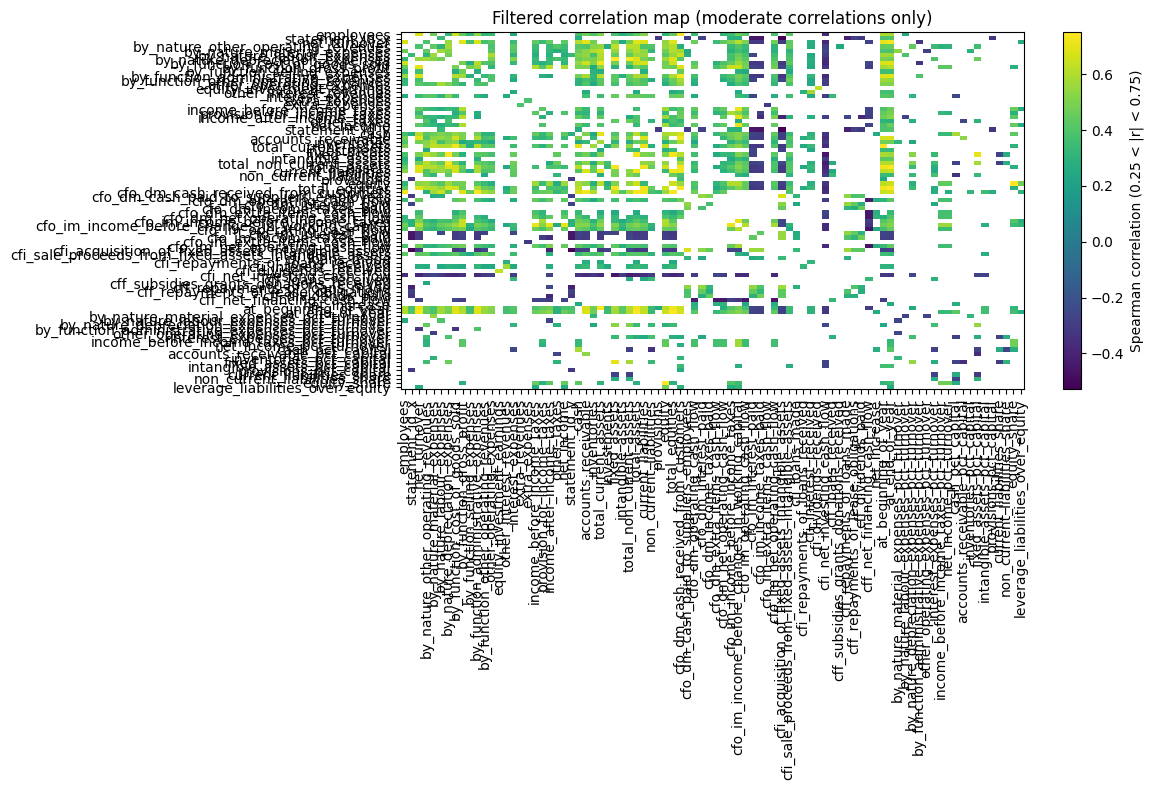

,var,moderate_links_count
0,at_end_of_year,53
1,at_beginning_of_year,51
2,equity,47
3,cfo_im_income_before_changes_in_working_capital,47
4,cash,45
5,total_assets,44
6,total_equities,44
7,total_non_current_assets,44
8,cfo_dm_cash_received_from_customers,42
9,net_turnover,41


X_clean shape: (670389, 100)
Filtered pairs found: 939


In [12]:

X_base = full.copy()


X = X_base.copy()

if "net_turnover" in X.columns:
    turnover = X["net_turnover"].replace({0: np.nan})

    is_cols = [
        "by_nature_material_expenses",
        "by_nature_labour_expenses",
        "by_nature_depreciation_expenses",
        "by_function_selling_expenses",
        "by_function_administrative_expenses",
        "other_operating_revenues",
        "other_operating_expenses",
        "interest_expenses",
        "income_before_income_taxes",
        "net_income",
    ]
    for c in is_cols:
        if c in X.columns:
            X[c + "_pct_turnover"] = X[c] / turnover

capital = (
    X.get("equity", 0)
    + X.get("current_liabilities", 0)
    + X.get("non_current_liabilities", 0)
    + X.get("provisions", 0)
).replace({0: np.nan})

bs_cols = ["cash","accounts_receivable","inventories","fixed_assets","intangible_assets","provisions"]
for c in bs_cols:
    if c in X.columns:
        X[c + "_pct_capital"] = X[c] / capital

if "current_liabilities" in X.columns and "non_current_liabilities" in X.columns:
    denom = (X["current_liabilities"] + X["non_current_liabilities"]).replace({0: np.nan})
    X["current_liabilities_share"] = X["current_liabilities"] / denom
    X["non_current_liabilities_share"] = X["non_current_liabilities"] / denom

if "equity" in X.columns and "current_liabilities" in X.columns and "non_current_liabilities" in X.columns:
    denom2 = (X["equity"] + X["current_liabilities"] + X["non_current_liabilities"]).replace({0: np.nan})
    X["equity_share"] = X["equity"] / denom2
    X["leverage_liabilities_over_equity"] = (
        (X["current_liabilities"] + X["non_current_liabilities"]) /
        X["equity"].replace({0: np.nan})
    )

# exclude obvious IDs
DROP_ALWAYS = {"id", "file_id", "year", "statement_id"}
num_cols = [c for c in X.columns if c not in DROP_ALWAYS and pd.api.types.is_numeric_dtype(X[c])]

X_clean = X[num_cols].replace([np.inf, -np.inf], np.nan)

# correlation + strong pairs + map + hubs
MIN_PERIODS = 5000

corr = X_clean.corr(method="spearman", min_periods=MIN_PERIODS)

pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .reset_index()
        .rename(columns={"level_0": "var_1", "level_1": "var_2", 0: "corr"})
)

pairs["abs_corr"] = pairs["corr"].abs()

# keeping ONLY correlations in (-0.75, -0.25) U (0.25, 0.75)
filtered_pairs = pairs[
    (pairs["abs_corr"] > 0.25) & (pairs["abs_corr"] < 0.75)
].sort_values("abs_corr", ascending=False)

display(filtered_pairs.head(100))

filtered_corr = corr.where(
    (np.abs(corr) > 0.25) & (np.abs(corr) < 0.75)
)
filtered_corr = filtered_corr.dropna(how="all").dropna(axis=1, how="all")

if filtered_corr.empty:
    print("No correlations in the range (0.25, 0.75).")
else:
    plt.figure(figsize=(12, 8))
    plt.imshow(filtered_corr, aspect="auto")
    plt.colorbar(label="Spearman correlation (0.25 < |r| < 0.75)")
    plt.xticks(range(len(filtered_corr.columns)), filtered_corr.columns, rotation=90)
    plt.yticks(range(len(filtered_corr.index)), filtered_corr.index)
    plt.title("Filtered correlation map (moderate correlations only)")
    plt.tight_layout()
    plt.show()

hub_counts = (
    pd.concat([
        filtered_pairs[["var_1"]].rename(columns={"var_1": "var"}),
        filtered_pairs[["var_2"]].rename(columns={"var_2": "var"})
    ])
    .value_counts()
    .rename("moderate_links_count")
    .reset_index()
    .rename(columns={"index": "var"})
)

display(hub_counts.head(30))

print("X_clean shape:", X_clean.shape)
print("Filtered pairs found:", len(filtered_pairs))